- Komang
- Bayu
- Yasmin

# **Import Library**

In [1]:
# Google Drive Public File/Folder Downloader
# https://pypi.org/project/gdown/
# https://github.com/wkentaro/gdown

!pip install -q -U gdown


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import gdown
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tlf
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer


# **Import Dataset**

- [How to download Google Drive file using Gdown in Python](https://github.com/wkentaro/gdown?tab=readme-ov-file#via-python)
- [How to download Google Drive file using Gdown in terminal command](https://github.com/wkentaro/gdown?tab=readme-ov-file#via-command-line)
- [How to use Python variable in Google Colab terminal command?](https://stackoverflow.com/questions/52851718/how-to-use-python-variables-in-google-colab-terminal-command)

In [3]:
rating_df = pd.read_csv('new_tourism_rating_comment.csv')
tourism_df = pd.read_csv('new_tourism_with_id_links.csv')
user_df = pd.read_csv('old_users_data.csv')
package_df = pd.read_csv('package_tourism.csv')
tourist_spots_df = pd.read_csv('tourist_spots_distance.csv')

# **Data Cleaning**


In [4]:
missing_values = {
    "tourism_data_missing": package_df.isnull().sum(),
    "tourism_rating_missing": rating_df.isnull().sum(),
    "new_tourism_with_id_missing": tourism_df.isnull().sum(),
    "user_missing": user_df.isnull().sum()
}

In [5]:
# Fill missing Time_Minutes with the median
tourism_df.fillna({
    'Time_Minutes': tourism_df['Time_Minutes'].median()
}, inplace=True)

In [6]:
print(tourism_df.columns)


Index(['Place_Id', 'Place_Name', 'Category', 'Description', 'City', 'Price',
       'Rating', 'Time_Minutes', 'Coordinate', 'Lat', 'Long', 'Img_Path_0',
       'Img_Path_1', 'Img_Path_2'],
      dtype='object')


Model Develompement Recommendation System

Content Based Filtering

Create tourism_one_hot_df

In [7]:
def get_one_hot_tourism_data(tourism_df: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
  """
  Preprocess the tourism dataframe by applying one-hot encoding to 'Category' and 'City',
  and dropping irrelevant columns.

  Args:
      tourism_df (pd.DataFrame): Original tourism dataframe.

  Returns:
      pd.DataFrame: Processed tourism dataframe with one-hot encoding applied.
  """
  # One-hot encoding untuk kolom Category dan City
  categories_one_hot = tourism_df['Category'].str.get_dummies(sep=', ')
  country_one_hot = tourism_df['City'].str.get_dummies()

  # Gabungkan dataframe asli dengan hasil one-hot encoding
  new_tourism_df = pd.concat([tourism_df, country_one_hot, categories_one_hot], axis=1)

  # Drop kolom yang tidak relevan
  tourism_one_hot_df = new_tourism_df.drop(columns=[
    'Place_Name', 'Category', 'Description', 'City', 'Coordinate',
    'Lat', 'Long', 'Img_Path_0', 'Img_Path_1', 'Img_Path_2'
  ])

  return tourism_one_hot_df, new_tourism_df

In [8]:
tourism_one_hot_df, new_tourism_df = get_one_hot_tourism_data(tourism_df)
tourism_one_hot_df

,Place_Id,Price,Rating,Time_Minutes,Bandung,Jakarta,Semarang,Surabaya,Yogyakarta,Bahari,...,Taman Hiburan,Taman Laut,Taman Nasional,Taman Rekreasi Anak,Teater & Pertunjukan,Tempat Ibadah,Tempat Menyelam,Toko Cinderamata,Warisan Arsitektur,Water Park
0,1,20000,"4,6",15.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,2,0,"4,6",90.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,270000,"4,6",360.0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,4,10000,"4,5",60.0,0,1,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
4,5,94000,"4,5",60.0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
432,433,2000,"4,4",45.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
433,434,0,"4,6",60.0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
434,435,0,"4,4",45.0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
435,436,0,"4,6",60.0,0,0,0,1,0,0,...,1,0,0,1,0,0,0,0,0,0


In [9]:
# Convert numeric columns with commas to proper float format
tourism_one_hot_df = tourism_one_hot_df.replace(',', '.', regex=True)
tourism_one_hot_df = tourism_one_hot_df.apply(pd.to_numeric, errors='coerce')


Create average_user_rating_df

In [10]:
def get_average_user_rating(new_tourism_df: pd.DataFrame, rating_df: pd.DataFrame) -> pd.DataFrame:
  """
  Calculate the average user ratings for tourism categories.

  This function preprocesses the tourism and rating dataframes to calculate
  the average ratings given by each user for various tourism categories.

  Args:
    new_tourism_df (pd.DataFrame): Dataframe containing tourism place
        information. It must include a 'Place_Id' column and one-hot
        encoded columns for tourism categories.
    rating_df (pd.DataFrame): Dataframe containing user ratings for places
      with columns 'Place_Id', 'User_Id', and 'Place_Ratings'.

  Returns:
    pd.DataFrame: A dataframe with average user ratings for each tourism
      category. The resulting dataframe includes:
        - 'User_Id': Unique identifier for users.
        - Columns corresponding to tourism categories with average ratings
          for each user.
    """

  # Daftar kategori
  categories = [
    'Bahari', 'Budaya', 'Cagar Alam', 'Hutan Lindung', 'Kebun Binatang',
    'Mall', 'Museum Sejarah', 'Museum Seni', 'Pantai', 'Pasar Tradisional',
    'Pulau', 'Pusat Perbelanjaan', 'Pusat Perbelanjaan Mewah', 'Situs Sejarah',
    'Suaka Margasatwa', 'Taman Air', 'Taman Bertema', 'Taman Edukasi',
    'Taman Hiburan', 'Taman Laut', 'Taman Nasional', 'Taman Rekreasi Anak',
    'Teater & Pertunjukan', 'Tempat Ibadah', 'Tempat Menyelam', 'Toko Cinderamata',
    'Warisan Arsitektur', 'Water Park'
  ]

  # Hapus kolom yang tidak diperlukan dari new_tourism_df
  tourism_category_only_one_hot_df = new_tourism_df.drop(columns=[
    'Place_Name', 'Category', 'Description', 'City', 'Price',
    'Rating', 'Time_Minutes', 'Coordinate', 'Lat', 'Long',
    'Img_Path_0', 'Img_Path_1', 'Img_Path_2', 'Bandung',
    'Jakarta', 'Semarang', 'Surabaya', 'Yogyakarta'
  ])

  # Gabungkan rating_df dengan tourism_category_only_one_hot_df berdasarkan 'Place_Id'
  rating_one_hot_df = rating_df.merge(
      tourism_category_only_one_hot_df, how='inner', on='Place_Id'
  )

  # Salin rating_one_hot_df untuk perhitungan
  rating_not_one_hot_df = rating_one_hot_df.copy()

  # Kalikan rating dengan setiap kategori untuk mendapatkan skor berbobot
  for category in categories:
    rating_not_one_hot_df[category] *= rating_not_one_hot_df['Place_Ratings']

  # Hitung total rating dan jumlah rating per kategori per pengguna
  total_count = rating_one_hot_df.groupby('User_Id')[categories].sum()
  total_rating = rating_not_one_hot_df.groupby('User_Id')[categories].sum()

  # Rata-rata rating untuk setiap kategori
  average_ratings = (total_rating / total_count).fillna(0).reset_index()

  # Tambahkan kolom User_Id ke hasil akhir
  average_user_rating_df = pd.concat([total_count.reset_index()[['User_Id']],
                                      average_ratings[categories]], axis=1)

  return average_user_rating_df

In [11]:
average_user_rating_df = get_average_user_rating(new_tourism_df, rating_df)
average_user_rating_df

,User_Id,Bahari,Budaya,Cagar Alam,Hutan Lindung,Kebun Binatang,Mall,Museum Sejarah,Museum Seni,Pantai,...,Taman Hiburan,Taman Laut,Taman Nasional,Taman Rekreasi Anak,Teater & Pertunjukan,Tempat Ibadah,Tempat Menyelam,Toko Cinderamata,Warisan Arsitektur,Water Park
0,1,2.000000,3.500000,3.444444,2.000000,5.0,0.0,3.750000,2.000000,0.0,...,3.800000,2.0,4.50,3.500000,2.500000,2.000000,0.000000,4.0,4.000000,0.000000
1,2,2.000000,3.444444,2.909091,2.333333,5.0,0.0,3.250000,5.000000,2.0,...,3.500000,0.0,3.00,2.666667,3.666667,4.000000,0.000000,0.0,2.000000,4.000000
2,3,5.000000,3.230769,4.000000,5.000000,0.0,0.0,3.200000,2.666667,0.0,...,3.000000,0.0,4.00,2.600000,3.500000,5.000000,5.000000,0.0,3.800000,4.000000
3,4,5.000000,3.076923,3.750000,3.000000,3.0,0.0,2.500000,5.000000,0.0,...,3.571429,5.0,5.00,4.000000,3.000000,0.000000,0.000000,0.0,2.714286,3.000000
4,5,3.500000,3.500000,3.000000,3.000000,2.0,0.0,3.200000,4.000000,5.0,...,3.500000,0.0,3.00,3.200000,3.000000,5.000000,0.000000,5.0,3.000000,3.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,296,2.000000,3.000000,3.333333,0.000000,4.0,0.0,1.000000,3.000000,0.0,...,3.000000,2.0,0.00,2.500000,4.000000,2.500000,0.000000,2.0,2.500000,3.000000
296,297,3.333333,3.090909,3.000000,5.000000,2.5,0.0,2.500000,4.000000,3.5,...,4.125000,0.0,3.00,3.500000,4.000000,2.333333,3.333333,0.0,2.000000,0.000000
297,298,2.750000,4.200000,3.444444,0.000000,1.0,0.0,4.333333,4.000000,1.0,...,4.000000,0.0,3.75,5.000000,4.000000,2.000000,0.000000,0.0,0.000000,3.333333
298,299,2.000000,3.083333,2.250000,2.000000,0.0,0.0,2.800000,0.000000,0.0,...,2.428571,2.0,2.50,3.000000,2.666667,4.000000,0.000000,3.0,2.666667,1.000000


Persiapan Data untuk Model

In [12]:
# One-hot encoding untuk kolom Category dan City
categories_one_hot = tourism_df['Category'].str.get_dummies(sep=', ')  # Untuk kategori wisata
city_one_hot = tourism_df['City'].str.get_dummies()  # Untuk kota


In [14]:
categories_one_hot

,Bahari,Budaya,Cagar Alam,Hutan Lindung,Kebun Binatang,Mall,Museum Sejarah,Museum Seni,Pantai,Pasar Tradisional,...,Taman Hiburan,Taman Laut,Taman Nasional,Taman Rekreasi Anak,Teater & Pertunjukan,Tempat Ibadah,Tempat Menyelam,Toko Cinderamata,Warisan Arsitektur,Water Park
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
432,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
433,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
434,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
435,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0


Persiapan data x dan y

In [ ]:
# Gabungkan rata-rata rating per pengguna dengan one-hot encoding untuk kategori dan kota
X_content = average_user_rating_df.merge(categories_one_hot, left_index=True, right_index=True)
X_content = X_content.merge(city_one_hot, left_index=True, right_index=True)

# Target: One-hot encoding untuk Place_Id
y = pd.get_dummies(rating_df['Place_Id']).values

# Verifikasi dimensi data
print(f"Shape of X_content: {X_content.shape}")
print(f"Shape of y (ratings matrix): {y.shape}")


Shape of X_content: (300, 62)
Shape of y (ratings matrix): (9597, 437)


Bangun Model

In [27]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

# Definisikan model dengan dropout, L2 regularization, dan early stopping
model = tf.keras.Sequential([
    layers.Input(shape=(X_content.shape[1],)),  # Input sesuai jumlah fitur
    layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dropout(0.3),  # Dropout untuk regularisasi
    layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dropout(0.3),  # Dropout untuk regularisasi
    layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dense(y.shape[1], activation='linear')  # Output sesuai jumlah tempat wisata
])

# Kompilasi model dengan optimizers Adam dan MAE sebagai metric evaluasi
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss='mean_squared_error',  # Loss MSE karena regresi
              metrics=['mae'])  # Metric MAE untuk regresi

# Callback EarlyStopping untuk menghentikan pelatihan lebih awal jika model tidak memperbaiki val_loss
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Melatih model dengan EarlyStopping
history = model.fit(X_content, y, epochs=20, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Ringkasan hasil training
history.history


Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 10.5107 - mae: 1.9731 - val_loss: 3.0643 - val_mae: 0.8455
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.4015 - mae: 0.7889 - val_loss: 2.0868 - val_mae: 0.4007
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4013 - mae: 0.5138 - val_loss: 1.8302 - val_mae: 0.2669
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.0566 - mae: 0.3892 - val_loss: 1.6292 - val_mae: 0.1027
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.8558 - mae: 0.3371 - val_loss: 1.5144 - val_mae: 0.0343
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6561 - mae: 0.2595 - val_loss: 1.4211 - val_mae: 0.0180
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5444 - mae: 0.2370 - val_loss: 1.3380 - val_mae: 0.0172
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4289 - mae: 0.2018 - val_loss: 1.2633 - val_mae: 0.0186
Epoch 9/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.3445 - mae: 0.1966 - val_los

{'loss': [8.275675773620605,
  3.2743732929229736,
  2.384803533554077,
  2.0230162143707275,
  1.811589002609253,
  1.6380304098129272,
  1.5322016477584839,
  1.4093867540359497,
  1.3211023807525635,
  1.2427031993865967,
  1.1902583837509155,
  1.12678861618042,
  1.0604325532913208,
  1.0109937191009521,
  0.98245769739151,
  0.9439014196395874,
  0.9073154330253601,
  0.8741922974586487,
  0.8341678380966187,
  0.8107207417488098],
 'mae': [1.6635355949401855,
  0.7678030729293823,
  0.5150295495986938,
  0.3844407796859741,
  0.3175949156284332,
  0.2577110230922699,
  0.23896925151348114,
  0.19737863540649414,
  0.18366996943950653,
  0.16527193784713745,
  0.16258686780929565,
  0.14843492209911346,
  0.1297190636396408,
  0.11774564534425735,
  0.130583718419075,
  0.11408627778291702,
  0.11319524794816971,
  0.10757473111152649,
  0.09047722071409225,
  0.08711154013872147],
 'val_loss': [3.0643198490142822,
  2.0868327617645264,
  1.8302375078201294,
  1.629204273223877,


In [ ]:
# Menyimpan model ke file .h5
# model.save('cbf_recommender_model.h5')


Plot Grafik Loss dan Akurasi

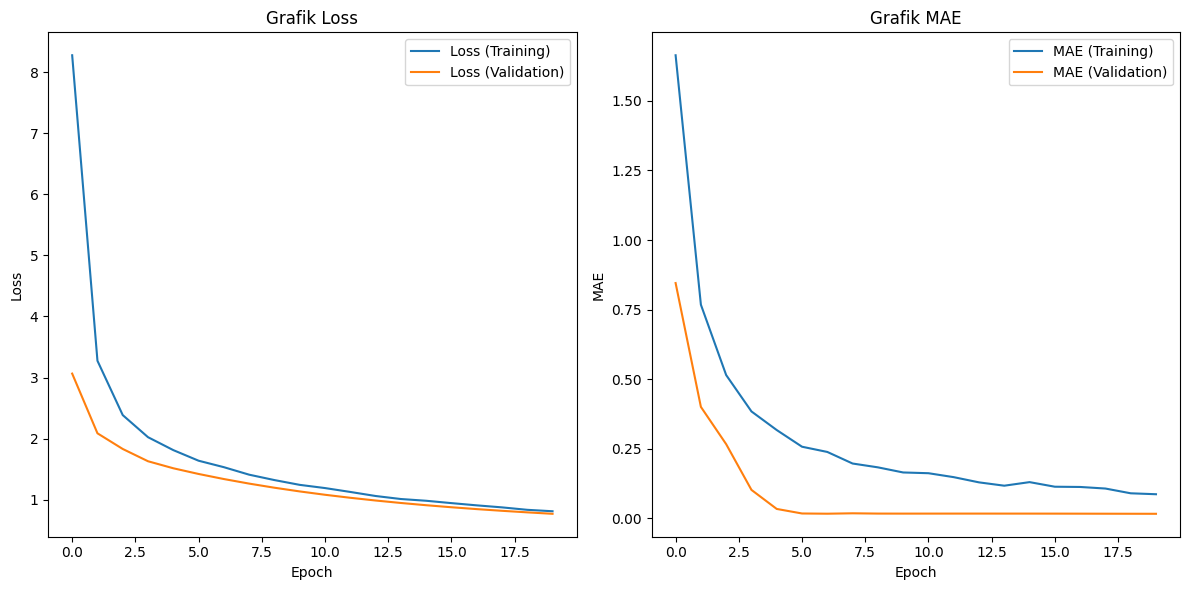

In [34]:
import matplotlib.pyplot as plt

# Grafik Loss dan MAE
plt.figure(figsize=(12, 6))

# Grafik Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss (Training)')
plt.plot(history.history['val_loss'], label='Loss (Validation)')
plt.title('Grafik Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Grafik MAE (Mean Absolute Error)
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='MAE (Training)')
plt.plot(history.history['val_mae'], label='MAE (Validation)')
plt.title('Grafik MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()


In [30]:
# Menyimpan model ke file H5 (format yang sering digunakan)
model.save('tourism_recommendation_model.h5')
print("Model telah disimpan.")


Model telah disimpan.


In [31]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model

# Fungsi untuk memuat model dan memberikan rekomendasi
def load_model_and_recommend(user_data, model_path='tourism_recommendation_model.h5', top_n=5):
    """
    Memuat model dan memberikan rekomendasi tempat wisata berdasarkan input pengguna.
    
    Args:
    - user_data (pd.DataFrame): Data pengguna yang mencakup rata-rata rating dan one-hot encoding
      untuk kategori dan kota.
    - model_path (str): Path ke file model yang disimpan.
    - top_n (int): Jumlah rekomendasi tempat wisata teratas yang akan diberikan.
    
    Returns:
    - rekomendasi (list): Daftar nama tempat wisata yang direkomendasikan.
    """
    # Memuat model yang disimpan
    model = load_model(model_path)
    
    # Prediksi rating untuk semua tempat wisata
    prediksi_rating = model.predict(user_data)
    
    # Ambil indeks tempat wisata dengan rating tertinggi
    rekomendasi_idx = np.argsort(prediksi_rating[0])[::-1][:top_n]
    
    # Ambil nama tempat wisata berdasarkan indeks yang terpilih
    rekomendasi = [place_names[idx] for idx in rekomendasi_idx]
    
    return rekomendasi

# Contoh penggunaan
# Misalkan 'user_data' adalah data pengguna yang sudah di-preprocess
# dan 'place_names' adalah list nama tempat wisata yang sesuai dengan indeksnya
user_data = X_content.iloc[0:1]  # Ambil data untuk pengguna pertama (misalnya)
place_names = new_tourism_df['Place_Name'].tolist()  # Daftar nama tempat wisata

rekomendasi = load_model_and_recommend(user_data)
print("Rekomendasi tempat wisata untuk pengguna:", rekomendasi)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Rekomendasi tempat wisata untuk pengguna: ['Setu Babakan', 'Museum Sumpah Pemuda', 'Heha Sky View', 'Museum Kesehatan Dr. Adhyatma', 'Goa Pindul']
